In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)

In [ ]:
# === Load Train & test datasets === #
project = Path.cwd().parent
target_folder = project / "0 - data"
train_df = pd.read_excel(target_folder / "train_clean.xlsx", sheet_name="Sheet1")
test_df = pd.read_excel(target_folder / "test_clean.xlsx", sheet_name="Sheet1")

target_col = "Automation Suitable"
drop_cols = ["Task ID", "Task Name"]
drop_cols = [c for c in drop_cols if c in train_df.columns]

X_train = train_df.drop(columns=[target_col] + drop_cols)
y_train = train_df[target_col]

X_test = test_df.drop(columns=[target_col] + drop_cols)
y_test = test_df[target_col]

In [ ]:
# === Load trained model === #
bundle = joblib.load(project / "2 - models/support_vector_machine_model.pkl")

svm_base = bundle["base"]
svm_tuned = bundle["tuned"]

print("✅ SVM model loaded.")

✅ SVM model loaded.


In [ ]:
# === Get Cross-validation accuracy === #
scores = cross_val_score(svm_base, X_train, y_train, cv=5, scoring="accuracy")
print(f"Cross-validation (Base Model) accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

scores = cross_val_score(svm_tuned, X_train, y_train, cv=5, scoring="accuracy")
print(f"Cross-validation (Tuned Model) accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Cross-validation (Base Model) accuracy: 0.8375 ± 0.0481
Cross-validation (Tuned Model) accuracy: 0.8450 ± 0.0232


In [ ]:
# === Predict on train/test (Base Model) === #
y_train_pred_base = svm_base.predict(X_train)
y_test_pred_base = svm_base.predict(X_test)

print("Training Accuracy (Base Model):", accuracy_score(y_train, y_train_pred_base))
print("Testing Accuracy (Base Model):", accuracy_score(y_test, y_test_pred_base))
print("\nConfusion Matrix (Base Model):\n", confusion_matrix(y_test, y_test_pred_base))
print("\nClassification Report (Base Model):\n", classification_report(y_test, y_test_pred_base))

Training Accuracy (Base Model): 0.8675
Testing Accuracy (Base Model): 0.92

Confusion Matrix (Base Model):
 [[46  8]
 [ 0 46]]

Classification Report (Base Model):
               precision    recall  f1-score   support

          No       1.00      0.85      0.92        54
         Yes       0.85      1.00      0.92        46

    accuracy                           0.92       100
   macro avg       0.93      0.93      0.92       100
weighted avg       0.93      0.92      0.92       100



In [ ]:
# === Predict on train/test (Tuned Model) === #
y_train_pred_tuned = svm_tuned.predict(X_train)
y_test_pred_tuned = svm_tuned.predict(X_test)

print("Training Accuracy (Tuned Model):", accuracy_score(y_train, y_train_pred_tuned))
print("Testing Accuracy (Tuned Model):", accuracy_score(y_test, y_test_pred_tuned))
print("\nConfusion Matrix (Tuned Model):\n", confusion_matrix(y_test, y_test_pred_tuned))
print("\nClassification Report (Tuned Model):\n", classification_report(y_test, y_test_pred_tuned))

Training Accuracy (Tuned Model): 0.8825
Testing Accuracy (Tuned Model): 0.92

Confusion Matrix (Tuned Model):
 [[46  8]
 [ 0 46]]

Classification Report (Tuned Model):
               precision    recall  f1-score   support

          No       1.00      0.85      0.92        54
         Yes       0.85      1.00      0.92        46

    accuracy                           0.92       100
   macro avg       0.93      0.93      0.92       100
weighted avg       0.93      0.92      0.92       100



In [ ]:
# === Probabilities + Feasibility % (Base Model) === #
proba = svm_base.predict_proba(X_test)

# Get "Yes" index safely
classes = list(svm_base.classes_) if hasattr(svm_base, "classes_") else list(svm_base.named_steps["model"].classes_)
yes_index_base = classes.index("Yes") if "Yes" in classes else 1

feasibility_pct = np.round(proba[:, yes_index_base] * 100, 2)

results_base = X_test.copy()
results_base["Actual"] = y_test.values
results_base["Predicted"] = y_test_pred_base
results_base["Feasibility %"] = feasibility_pct
results_base["Model"] = "SVM (Base Model)"

results_base.head(10)

,Time Taken (mins),Complexity (1-5),Frequency,Tool Used,Department,Error Rate (%),Rule-Based Indicator,Process Stability,Data Structure,Actual,Predicted,Feasibility %,Model
0,0.380295,2,Quarterly,Trello,Customer Service,-1.058714,Yes,Medium,Semi-Structured,Yes,Yes,89.03,SVM (Base Model)
1,-0.652825,2,Ad-Hoc,Slack,Procurement,-1.529068,Yes,Low,Unstructured,No,Yes,69.30,SVM (Base Model)
2,0.896855,4,Monthly,Jira,Human Resource,-0.552179,No,Medium,Semi-Structured,Yes,Yes,90.29,SVM (Base Model)
3,-1.418758,3,Quarterly,SAP,Compliance,-0.552179,Yes,Low,Unstructured,No,No,13.31,SVM (Base Model)
4,-0.243139,2,Ad-Hoc,Google Sheets,IT,0.460891,No,Medium,Structured,No,No,3.83,SVM (Base Model)
5,1.235290,5,Weekly,Slack,Sales,0.000608,No,Low,Unstructured,Yes,Yes,52.76,SVM (Base Model)
6,0.647481,1,Monthly,Custom Portal,Compliance,0.641796,Yes,Medium,Semi-Structured,No,No,1.32,SVM (Base Model)
7,0.540607,5,Ad-Hoc,Excel,IT,-0.190368,No,Medium,Structured,No,No,11.55,SVM (Base Model)
8,-1.507820,2,Weekly,Google Sheets,IT,-0.262730,Yes,High,Structured,Yes,Yes,66.97,SVM (Base Model)
9,0.326858,1,Quarterly,Jira,Admin,-1.203438,Yes,Medium,Semi-Structured,Yes,Yes,98.28,SVM (Base Model)


ROC AUC (Base Model): 0.9649758454106281


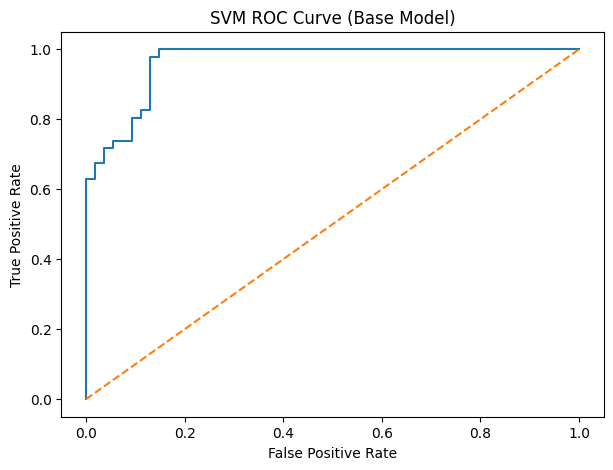

In [ ]:
# === ROC AUC + Curve (Base Model) === #
y_true = (y_test == "Yes").astype(int)
auc = roc_auc_score(y_true, proba[:, yes_index_base])
print("ROC AUC (Base Model):", auc)

fpr, tpr, _ = roc_curve(y_true, proba[:, yes_index_base])

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM ROC Curve (Base Model)")
plt.show()

In [ ]:
# === Probabilities + Feasibility % (Tuned Model) === #v
proba = svm_tuned.predict_proba(X_test)

# Get "Yes" index safely
classes = list(svm_tuned.classes_) if hasattr(svm_tuned, "classes_") else list(svm_tuned.named_steps["model"].classes_)
yes_index_tuned = classes.index("Yes") if "Yes" in classes else 1

feasibility_pct = np.round(proba[:, yes_index_tuned] * 100, 2)

results_tuned = X_test.copy()
results_tuned["Actual"] = y_test.values
results_tuned["Predicted"] = y_test_pred_tuned
results_tuned["Feasibility %"] = feasibility_pct
results_tuned["Model"] = "SVM (Tuned Model)"

results_tuned.head(10)

,Time Taken (mins),Complexity (1-5),Frequency,Tool Used,Department,Error Rate (%),Rule-Based Indicator,Process Stability,Data Structure,Actual,Predicted,Feasibility %,Model
0,0.380295,2,Quarterly,Trello,Customer Service,-1.058714,Yes,Medium,Semi-Structured,Yes,Yes,90.64,SVM (Tuned Model)
1,-0.652825,2,Ad-Hoc,Slack,Procurement,-1.529068,Yes,Low,Unstructured,No,Yes,78.39,SVM (Tuned Model)
2,0.896855,4,Monthly,Jira,Human Resource,-0.552179,No,Medium,Semi-Structured,Yes,Yes,90.08,SVM (Tuned Model)
3,-1.418758,3,Quarterly,SAP,Compliance,-0.552179,Yes,Low,Unstructured,No,No,14.66,SVM (Tuned Model)
4,-0.243139,2,Ad-Hoc,Google Sheets,IT,0.460891,No,Medium,Structured,No,No,8.32,SVM (Tuned Model)
5,1.235290,5,Weekly,Slack,Sales,0.000608,No,Low,Unstructured,Yes,Yes,74.66,SVM (Tuned Model)
6,0.647481,1,Monthly,Custom Portal,Compliance,0.641796,Yes,Medium,Semi-Structured,No,No,1.29,SVM (Tuned Model)
7,0.540607,5,Ad-Hoc,Excel,IT,-0.190368,No,Medium,Structured,No,No,16.25,SVM (Tuned Model)
8,-1.507820,2,Weekly,Google Sheets,IT,-0.262730,Yes,High,Structured,Yes,Yes,67.05,SVM (Tuned Model)
9,0.326858,1,Quarterly,Jira,Admin,-1.203438,Yes,Medium,Semi-Structured,Yes,Yes,98.10,SVM (Tuned Model)


ROC AUC (Tuned Model): 0.9681964573268921


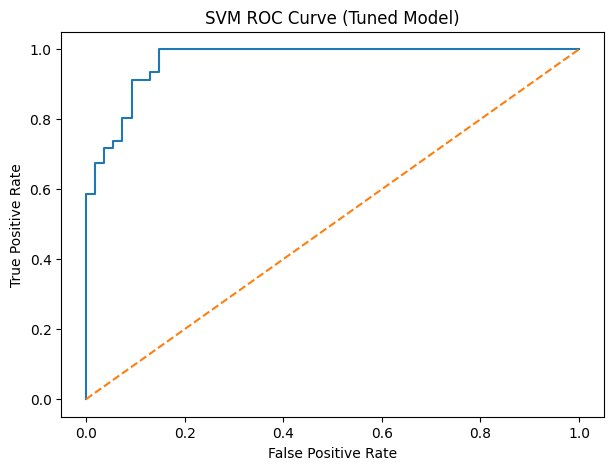

In [ ]:
# === ROC AUC + Curve (Tuned Model) === #
y_true = (y_test == "Yes").astype(int)
auc = roc_auc_score(y_true, proba[:, yes_index_tuned])
print("ROC AUC (Tuned Model):", auc)

fpr, tpr, _ = roc_curve(y_true, proba[:, yes_index_tuned])

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM ROC Curve (Tuned Model)")
plt.show()

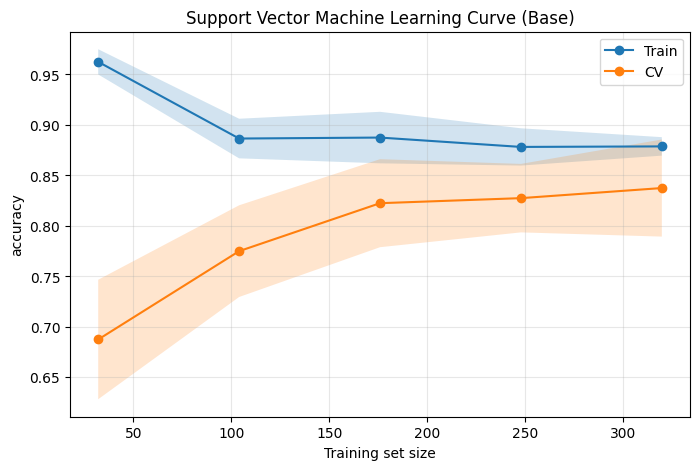

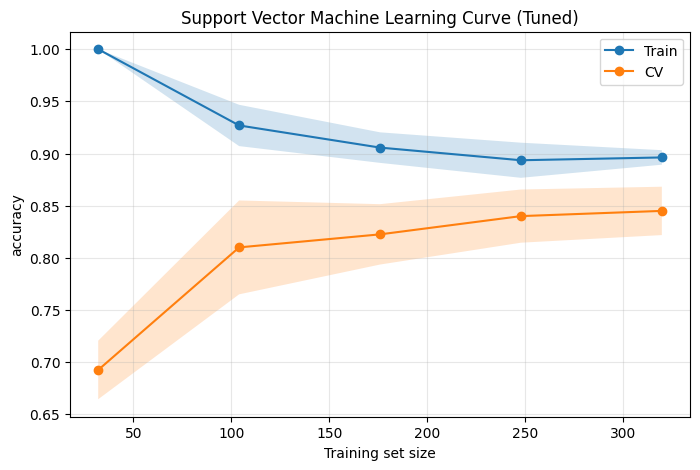

In [ ]:
# === Plot Learning Curve === #
def plot_learning_curve(
    estimator,
    X,
    y,
    title="Learning Curve",
    scoring="accuracy",
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
):
    sizes, train_scores, val_scores = learning_curve(
        estimator=estimator,
        X=X,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        shuffle=True,
        random_state=42
    )

    train_mean = train_scores.mean(axis=1)
    train_std  = train_scores.std(axis=1)

    val_mean = val_scores.mean(axis=1)
    val_std  = val_scores.std(axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(sizes, train_mean, marker="o", label="Train")
    plt.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

    plt.plot(sizes, val_mean, marker="o", label="CV")
    plt.fill_between(sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

    plt.title(title)
    plt.xlabel("Training set size")
    plt.ylabel(scoring)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_learning_curve(
    estimator=svm_base,
    X=X_train,
    y=y_train,
    title="Support Vector Machine Learning Curve (Base)",
    scoring="accuracy",
    cv=5
)

plot_learning_curve(
    estimator=svm_tuned,
    X=X_train,
    y=y_train,
    title="Support Vector Machine Learning Curve (Tuned)",
    scoring="accuracy",
    cv=5
)

In [ ]:
# === Save prediction results to CSV (Base & Tuned set) === #
export_path_base = project / "3 - evaluation/support_vector_machine_base_model_summary.csv"
results_to_save_base = results_base.copy()
results_to_save_base["Model"] = "SVM (Base Model)"
results_to_save_base.to_csv(export_path_base, index=False)
print(f"✅ Prediction summary saved to: {export_path_base}")

export_path_tuned = project / "3 - evaluation/support_vector_machine_tuned_model_summary.csv"
results_to_save_tuned = results_base.copy()
results_to_save_tuned["Model"] = "SVM (Tuned Model)"
results_to_save_tuned.to_csv(export_path_tuned, index=False)
print(f"✅ Prediction summary saved to: {export_path_tuned}")

✅ Prediction summary saved to: c:\Users\victo\Desktop\project\3 - evaluation\support_vector_machine_base_model_summary.csv
✅ Prediction summary saved to: c:\Users\victo\Desktop\project\3 - evaluation\support_vector_machine_tuned_model_summary.csv
